# Imports

In [ ]:
!pip install keras_unet_collection

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 67.9/67.9 kB 1.8 MB/s eta 0:00:00


In [ ]:
import os
import cv2
import numpy as np
from matplotlib import pyplot as plt
import glob
from datetime import datetime
from PIL import Image
import random
import tensorflow as tf

from tensorflow.keras.optimizers import Adam
from keras.callbacks import ModelCheckpoint, EarlyStopping
from tensorflow.keras.metrics import MeanIoU

from keras_unet_collection import losses

from sklearn.model_selection import train_test_split

# Get dataset

In [ ]:
!wget -O augmented_dataset3200.zip https://www.dropbox.com/s/dbu916o3ki5fh5j/augmented_dataset3200.zip?dl=0
!unzip /content/augmented_dataset3200.zip

## Process images

In [ ]:
augmented_images_dir_path = "/content/augmented_images"
augmented_masks_dir_path =  "/content/augmented_masks"

In [ ]:
image_names = glob.glob(f"{augmented_images_dir_path}/*.jpg")
image_names.sort()


image_dataset = []

for image_name in image_names:
      image = cv2.imread(image_name, 1)
      image = Image.fromarray(image)
      image_dataset.append(np.array(image))

In [ ]:
mask_names = glob.glob(f"{augmented_masks_dir_path}/*.png")
mask_names.sort()

mask_dataset = []

for image_name in mask_names:
        image = cv2.imread(image_name, 0)
        image = np.where(image>0, 255, image)
        image = Image.fromarray(image)
        mask_dataset.append(np.array(image))

In [ ]:
names = []
for i in range(len(os.listdir(augmented_masks_dir_path))):
  img_name = image_names[i].split("/")[-1]
  mask_name = mask_names[i].split("/")[-1]

  n1 = img_name.split(".")[0]
  n2 = mask_name.split(".")[0]
  names.append(n1==n2)

all(names)

True

In [ ]:
image_dataset = np.array(image_dataset)/255.
mask_dataset = np.expand_dims((np.array(mask_dataset)),3) /255.

#Split data for train and test

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(image_dataset, mask_dataset, test_size = 0.20, random_state = 9)

In [ ]:
X_train.shape

(2560, 256, 256, 3)

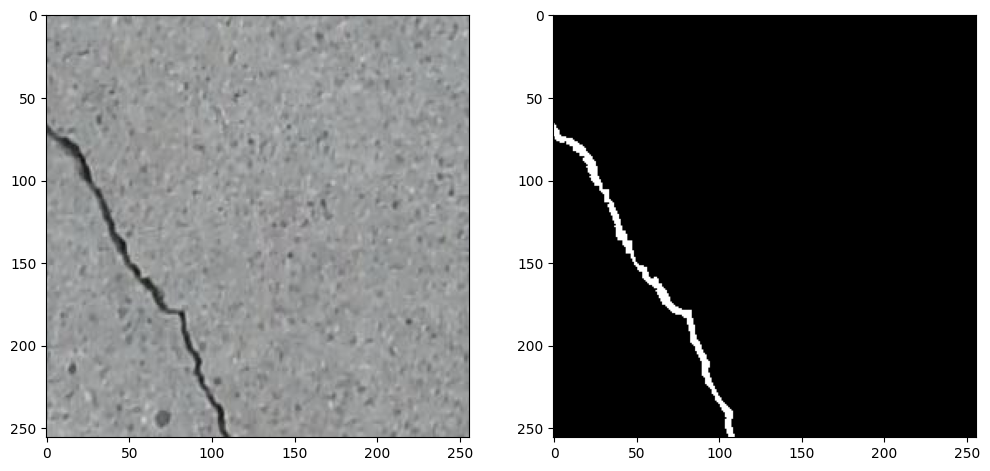

In [ ]:
#Sanity check
image_number = random.randint(0, len(X_train))
plt.figure(figsize=(12, 6))
plt.subplot(121)
plt.imshow(np.reshape(X_train[image_number], (256, 256, 3)), cmap='gray')
plt.subplot(122)
plt.imshow(np.reshape(y_train[image_number], (256, 256)), cmap='gray')
plt.show()

# Trans U-Net

## Settings

In [ ]:
metrics_set=[ tf.keras.metrics.BinaryIoU(target_class_ids=[1]), losses.dice_coef]

In [ ]:
IMG_HEIGHT = X_train.shape[1]
IMG_WIDTH  = X_train.shape[2]
IMG_CHANNELS = X_train.shape[3]
input_shape = (IMG_HEIGHT,IMG_WIDTH,IMG_CHANNELS)
num_labels = 1  #Binary
batch_size = 8
epochs = 50

In [ ]:
!mkdir /content/trans_unet_checkpoints

filepath = '/content/trans_unet_checkpoints/transunet_model.h5'
checkpoint = ModelCheckpoint(filepath=filepath,
                             monitor="val_dice_coef",
                             verbose=1,
                             save_best_only=True,
                             mode="max")

earlyStopping = EarlyStopping(patience=5)

callbacks = [checkpoint, earlyStopping]

## Fitting

In [ ]:
from keras_unet_collection.models import transunet_2d

In [ ]:
model = transunet_2d((256, 256, 3),
            filter_num=[64, 128, 256, 512, 1024],
            n_labels=1,
            activation='ReLU',
            mlp_activation='GELU',
            output_activation='Sigmoid',
            num_heads=6,
            num_transformer=6,
            batch_norm=True,
            backbone='VGG16',
            weights='imagenet',
            name='transunet')

In [ ]:
model.compile(loss=tf.keras.losses.binary_crossentropy,
              optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4),
              metrics=metrics_set)

In [ ]:
start = datetime.now()
history = model.fit(X_train, y_train,
                    verbose=1,
                    batch_size = batch_size,
                    validation_data=(X_test, y_test ),
                    epochs=epochs,
                    callbacks=callbacks)

stop = datetime.now()

Epoch 1/50
320/320 [==============================] - ETA: 0s - loss: 0.1594 - binary_io_u: 0.3186 - dice_coef: 0.1650
Epoch 1: val_dice_coef improved from -inf to 0.05254, saving model to /content/trans_unet_checkpoints/transunet_model.h5


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


320/320 [==============================] - 182s 473ms/step - loss: 0.1594 - binary_io_u: 0.3186 - dice_coef: 0.1650 - val_loss: 3.3562 - val_binary_io_u: 0.0313 - val_dice_coef: 0.0525
Epoch 2/50
320/320 [==============================] - ETA: 0s - loss: 0.0595 - binary_io_u: 0.7084 - dice_coef: 0.2703
Epoch 2: val_dice_coef improved from 0.05254 to 0.24724, saving model to /content/trans_unet_checkpoints/transunet_model.h5


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


320/320 [==============================] - 143s 446ms/step - loss: 0.0595 - binary_io_u: 0.7084 - dice_coef: 0.2703 - val_loss: 0.0552 - val_binary_io_u: 0.7052 - val_dice_coef: 0.2472
Epoch 3/50
320/320 [==============================] - ETA: 0s - loss: 0.0415 - binary_io_u: 0.7338 - dice_coef: 0.3498
Epoch 3: val_dice_coef improved from 0.24724 to 0.35559, saving model to /content/trans_unet_checkpoints/transunet_model.h5


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


320/320 [==============================] - 141s 442ms/step - loss: 0.0415 - binary_io_u: 0.7338 - dice_coef: 0.3498 - val_loss: 0.0352 - val_binary_io_u: 0.7312 - val_dice_coef: 0.3556
Epoch 4/50
320/320 [==============================] - ETA: 0s - loss: 0.0356 - binary_io_u: 0.7282 - dice_coef: 0.4037
Epoch 4: val_dice_coef improved from 0.35559 to 0.36859, saving model to /content/trans_unet_checkpoints/transunet_model.h5


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


320/320 [==============================] - 144s 452ms/step - loss: 0.0356 - binary_io_u: 0.7282 - dice_coef: 0.4037 - val_loss: 0.0362 - val_binary_io_u: 0.7171 - val_dice_coef: 0.3686
Epoch 5/50
320/320 [==============================] - ETA: 0s - loss: 0.0258 - binary_io_u: 0.7398 - dice_coef: 0.4784
Epoch 5: val_dice_coef improved from 0.36859 to 0.52334, saving model to /content/trans_unet_checkpoints/transunet_model.h5


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


320/320 [==============================] - 139s 435ms/step - loss: 0.0258 - binary_io_u: 0.7398 - dice_coef: 0.4784 - val_loss: 0.0194 - val_binary_io_u: 0.7234 - val_dice_coef: 0.5233
Epoch 6/50
320/320 [==============================] - ETA: 0s - loss: 0.0200 - binary_io_u: 0.7559 - dice_coef: 0.5410
Epoch 6: val_dice_coef improved from 0.52334 to 0.52523, saving model to /content/trans_unet_checkpoints/transunet_model.h5


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


320/320 [==============================] - 152s 476ms/step - loss: 0.0200 - binary_io_u: 0.7559 - dice_coef: 0.5410 - val_loss: 0.0196 - val_binary_io_u: 0.7555 - val_dice_coef: 0.5252
Epoch 7/50
320/320 [==============================] - ETA: 0s - loss: 0.0166 - binary_io_u: 0.7636 - dice_coef: 0.5940
Epoch 7: val_dice_coef improved from 0.52523 to 0.60916, saving model to /content/trans_unet_checkpoints/transunet_model.h5


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


320/320 [==============================] - 142s 445ms/step - loss: 0.0166 - binary_io_u: 0.7636 - dice_coef: 0.5940 - val_loss: 0.0150 - val_binary_io_u: 0.7549 - val_dice_coef: 0.6092
Epoch 8/50
320/320 [==============================] - ETA: 0s - loss: 0.0153 - binary_io_u: 0.7594 - dice_coef: 0.6254
Epoch 8: val_dice_coef did not improve from 0.60916
320/320 [==============================] - 140s 438ms/step - loss: 0.0153 - binary_io_u: 0.7594 - dice_coef: 0.6254 - val_loss: 0.0172 - val_binary_io_u: 0.6451 - val_dice_coef: 0.6005
Epoch 9/50
320/320 [==============================] - ETA: 0s - loss: 0.0134 - binary_io_u: 0.7637 - dice_coef: 0.6547
Epoch 9: val_dice_coef did not improve from 0.60916
320/320 [==============================] - 138s 431ms/step - loss: 0.0134 - binary_io_u: 0.7637 - dice_coef: 0.6547 - val_loss: 0.0184 - val_binary_io_u: 0.7361 - val_dice_coef: 0.5739
Epoch 10/50
320/320 [==============================] - ETA: 0s - loss: 0.0119 - binary_io_u: 0.7701 - d

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


320/320 [==============================] - 141s 442ms/step - loss: 0.0119 - binary_io_u: 0.7701 - dice_coef: 0.6833 - val_loss: 0.0115 - val_binary_io_u: 0.7551 - val_dice_coef: 0.6847
Epoch 11/50
320/320 [==============================] - ETA: 0s - loss: 0.0110 - binary_io_u: 0.7712 - dice_coef: 0.7091
Epoch 11: val_dice_coef did not improve from 0.68473
320/320 [==============================] - 139s 434ms/step - loss: 0.0110 - binary_io_u: 0.7712 - dice_coef: 0.7091 - val_loss: 0.0183 - val_binary_io_u: 0.7011 - val_dice_coef: 0.6430
Epoch 12/50
320/320 [==============================] - ETA: 0s - loss: 0.0102 - binary_io_u: 0.7740 - dice_coef: 0.7274
Epoch 12: val_dice_coef improved from 0.68473 to 0.71994, saving model to /content/trans_unet_checkpoints/transunet_model.h5


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


320/320 [==============================] - 144s 450ms/step - loss: 0.0102 - binary_io_u: 0.7740 - dice_coef: 0.7274 - val_loss: 0.0109 - val_binary_io_u: 0.7463 - val_dice_coef: 0.7199
Epoch 13/50
320/320 [==============================] - ETA: 0s - loss: 0.0096 - binary_io_u: 0.7776 - dice_coef: 0.7452
Epoch 13: val_dice_coef improved from 0.71994 to 0.75512, saving model to /content/trans_unet_checkpoints/transunet_model.h5


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


320/320 [==============================] - 156s 487ms/step - loss: 0.0096 - binary_io_u: 0.7776 - dice_coef: 0.7452 - val_loss: 0.0095 - val_binary_io_u: 0.7626 - val_dice_coef: 0.7551
Epoch 14/50
320/320 [==============================] - ETA: 0s - loss: 0.0091 - binary_io_u: 0.7800 - dice_coef: 0.7582
Epoch 14: val_dice_coef did not improve from 0.75512
320/320 [==============================] - 139s 434ms/step - loss: 0.0091 - binary_io_u: 0.7800 - dice_coef: 0.7582 - val_loss: 0.0112 - val_binary_io_u: 0.7380 - val_dice_coef: 0.7214
Epoch 15/50
320/320 [==============================] - ETA: 0s - loss: 0.0087 - binary_io_u: 0.7817 - dice_coef: 0.7693
Epoch 15: val_dice_coef improved from 0.75512 to 0.76501, saving model to /content/trans_unet_checkpoints/transunet_model.h5


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


320/320 [==============================] - 134s 418ms/step - loss: 0.0087 - binary_io_u: 0.7817 - dice_coef: 0.7693 - val_loss: 0.0091 - val_binary_io_u: 0.7689 - val_dice_coef: 0.7650
Epoch 16/50
320/320 [==============================] - ETA: 0s - loss: 0.0090 - binary_io_u: 0.7754 - dice_coef: 0.7665
Epoch 16: val_dice_coef did not improve from 0.76501
320/320 [==============================] - 135s 422ms/step - loss: 0.0090 - binary_io_u: 0.7754 - dice_coef: 0.7665 - val_loss: 0.0092 - val_binary_io_u: 0.7497 - val_dice_coef: 0.7630
Epoch 17/50
320/320 [==============================] - ETA: 0s - loss: 0.0087 - binary_io_u: 0.7722 - dice_coef: 0.7746
Epoch 17: val_dice_coef did not improve from 0.76501
320/320 [==============================] - 141s 440ms/step - loss: 0.0087 - binary_io_u: 0.7722 - dice_coef: 0.7746 - val_loss: 0.0307 - val_binary_io_u: 0.3366 - val_dice_coef: 0.4494
Epoch 18/50
320/320 [==============================] - ETA: 0s - loss: 0.0082 - binary_io_u: 0.7782

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


320/320 [==============================] - 143s 446ms/step - loss: 0.0082 - binary_io_u: 0.7782 - dice_coef: 0.7888 - val_loss: 0.0087 - val_binary_io_u: 0.7627 - val_dice_coef: 0.7747
Epoch 19/50
320/320 [==============================] - ETA: 0s - loss: 0.0078 - binary_io_u: 0.7856 - dice_coef: 0.7963
Epoch 19: val_dice_coef improved from 0.77466 to 0.78671, saving model to /content/trans_unet_checkpoints/transunet_model.h5


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


320/320 [==============================] - 147s 458ms/step - loss: 0.0078 - binary_io_u: 0.7856 - dice_coef: 0.7963 - val_loss: 0.0083 - val_binary_io_u: 0.7679 - val_dice_coef: 0.7867
Epoch 20/50
320/320 [==============================] - ETA: 0s - loss: 0.0076 - binary_io_u: 0.7881 - dice_coef: 0.8017
Epoch 20: val_dice_coef improved from 0.78671 to 0.78961, saving model to /content/trans_unet_checkpoints/transunet_model.h5


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


320/320 [==============================] - 144s 450ms/step - loss: 0.0076 - binary_io_u: 0.7881 - dice_coef: 0.8017 - val_loss: 0.0085 - val_binary_io_u: 0.7604 - val_dice_coef: 0.7896
Epoch 21/50
320/320 [==============================] - ETA: 0s - loss: 0.0075 - binary_io_u: 0.7877 - dice_coef: 0.8039
Epoch 21: val_dice_coef improved from 0.78961 to 0.79304, saving model to /content/trans_unet_checkpoints/transunet_model.h5


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


320/320 [==============================] - 144s 451ms/step - loss: 0.0075 - binary_io_u: 0.7877 - dice_coef: 0.8039 - val_loss: 0.0087 - val_binary_io_u: 0.7640 - val_dice_coef: 0.7930
Epoch 22/50
320/320 [==============================] - ETA: 0s - loss: 0.0074 - binary_io_u: 0.7903 - dice_coef: 0.8072
Epoch 22: val_dice_coef improved from 0.79304 to 0.79734, saving model to /content/trans_unet_checkpoints/transunet_model.h5


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


320/320 [==============================] - 144s 449ms/step - loss: 0.0074 - binary_io_u: 0.7903 - dice_coef: 0.8072 - val_loss: 0.0082 - val_binary_io_u: 0.7662 - val_dice_coef: 0.7973
Epoch 23/50
320/320 [==============================] - ETA: 0s - loss: 0.0072 - binary_io_u: 0.7911 - dice_coef: 0.8123
Epoch 23: val_dice_coef improved from 0.79734 to 0.80256, saving model to /content/trans_unet_checkpoints/transunet_model.h5


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


320/320 [==============================] - 144s 450ms/step - loss: 0.0072 - binary_io_u: 0.7911 - dice_coef: 0.8123 - val_loss: 0.0082 - val_binary_io_u: 0.7670 - val_dice_coef: 0.8026
Epoch 24/50
320/320 [==============================] - ETA: 0s - loss: 0.0071 - binary_io_u: 0.7923 - dice_coef: 0.8151
Epoch 24: val_dice_coef did not improve from 0.80256
320/320 [==============================] - 134s 419ms/step - loss: 0.0071 - binary_io_u: 0.7923 - dice_coef: 0.8151 - val_loss: 0.0085 - val_binary_io_u: 0.7632 - val_dice_coef: 0.7946
Epoch 25/50
320/320 [==============================] - ETA: 0s - loss: 0.0071 - binary_io_u: 0.7931 - dice_coef: 0.8165
Epoch 25: val_dice_coef did not improve from 0.80256
320/320 [==============================] - 141s 443ms/step - loss: 0.0071 - binary_io_u: 0.7931 - dice_coef: 0.8165 - val_loss: 0.0083 - val_binary_io_u: 0.7631 - val_dice_coef: 0.7978
Epoch 26/50
320/320 [==============================] - ETA: 0s - loss: 0.0072 - binary_io_u: 0.7920

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


320/320 [==============================] - 141s 440ms/step - loss: 0.0069 - binary_io_u: 0.7965 - dice_coef: 0.8227 - val_loss: 0.0082 - val_binary_io_u: 0.7719 - val_dice_coef: 0.8143
Epoch 29/50
320/320 [==============================] - ETA: 0s - loss: 0.0068 - binary_io_u: 0.7970 - dice_coef: 0.8257
Epoch 29: val_dice_coef did not improve from 0.81430
320/320 [==============================] - 147s 461ms/step - loss: 0.0068 - binary_io_u: 0.7970 - dice_coef: 0.8257 - val_loss: 0.0084 - val_binary_io_u: 0.7664 - val_dice_coef: 0.8092
Epoch 30/50
320/320 [==============================] - ETA: 0s - loss: 0.0067 - binary_io_u: 0.7996 - dice_coef: 0.8286
Epoch 30: val_dice_coef did not improve from 0.81430
320/320 [==============================] - 144s 452ms/step - loss: 0.0067 - binary_io_u: 0.7996 - dice_coef: 0.8286 - val_loss: 0.0091 - val_binary_io_u: 0.7568 - val_dice_coef: 0.8092
Epoch 31/50
320/320 [==============================] - ETA: 0s - loss: 0.0066 - binary_io_u: 0.8017

In [ ]:
print(f"Execution time: {stop-start}")

Execution time: 1:16:16.842083


# Training history

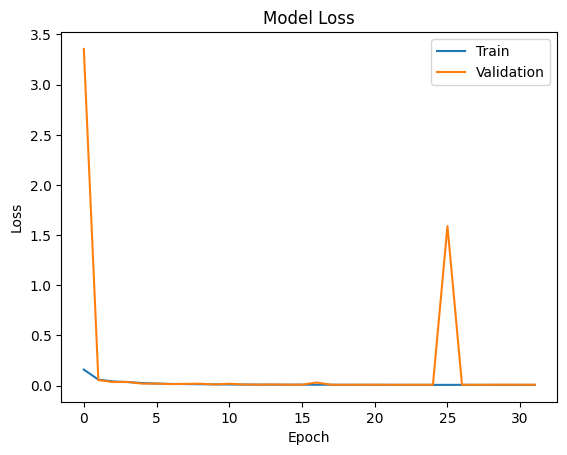

In [ ]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(['Train', 'Validation'], loc='upper right')
plt.show()

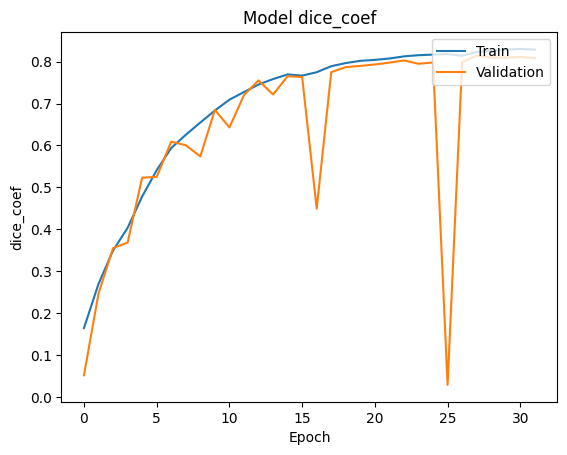

In [ ]:
plt.plot(history.history['dice_coef'])
plt.plot(history.history['val_dice_coef'])
plt.title('Model dice_coef')
plt.xlabel('Epoch')
plt.ylabel('dice_coef')
plt.legend(['Train', 'Validation'], loc='upper right')
plt.show()

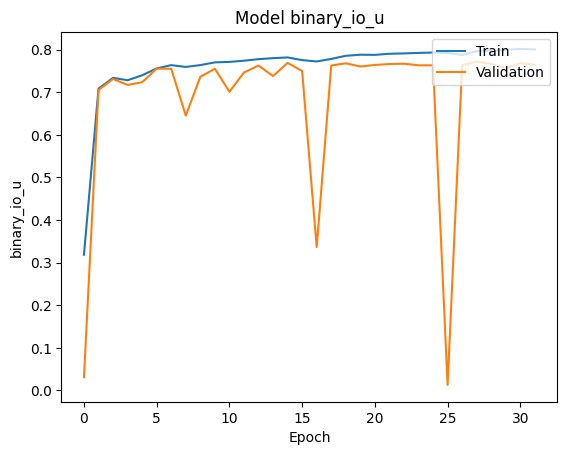

In [ ]:
plt.plot(history.history['binary_io_u'])
plt.plot(history.history['val_binary_io_u'])
plt.title('Model binary_io_u')
plt.xlabel('Epoch')
plt.ylabel('binary_io_u')
plt.legend(['Train', 'Validation'], loc='upper right')
plt.show()

# Metrics

## Ground truth vs prediction

1/1 [==============================] - 0s 36ms/step


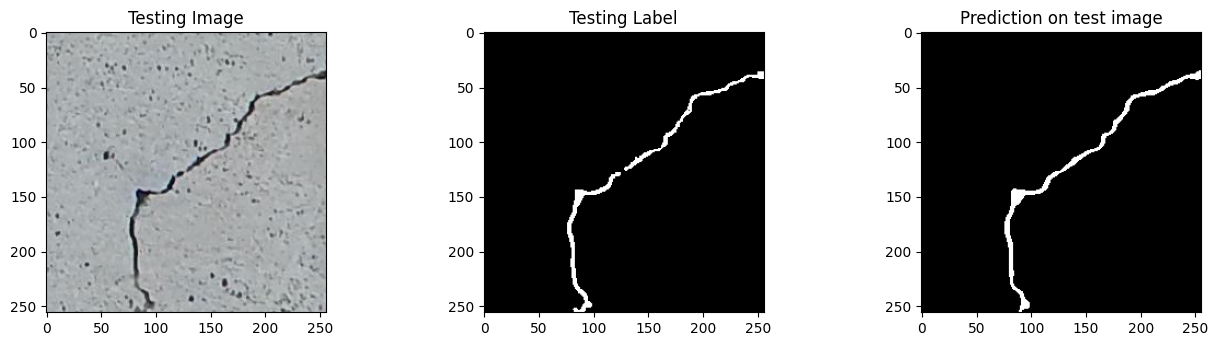

In [ ]:
import random
test_img_number = random.randint(0, X_test.shape[0]-1)
test_img = X_test[test_img_number]
ground_truth=y_test[test_img_number]

test_img_input=np.expand_dims(test_img, 0)
prediction = (transunet_model.predict(test_img_input)[0,:,:,0] > 0.5).astype(np.uint8)

plt.figure(figsize=(16, 8))
plt.subplot(231)
plt.title('Testing Image')
plt.imshow(test_img, cmap='gray')
plt.subplot(232)
plt.title('Testing Label')
plt.imshow(ground_truth[:,:,0], cmap='gray')
plt.subplot(233)
plt.title('Prediction on test image')
plt.imshow(prediction, cmap='gray')

plt.show()

## IoU for test dataset

In [ ]:
import pandas as pd
n_classes = 2

IoU_values = []
for img in range(0, X_test.shape[0]):
    temp_img = X_test[img]
    ground_truth=y_test[img]
    temp_img_input=np.expand_dims(temp_img, 0)
    prediction = (transunet_model.predict(temp_img_input)[0,:,:,0] > 0.5).astype(np.uint8)

    IoU = MeanIoU(num_classes=n_classes)
    IoU.update_state(ground_truth[:,:,0], prediction)
    IoU = IoU.result().numpy()
    IoU_values.append(IoU)

df = pd.DataFrame(IoU_values, columns=["IoU"])
df = df[df.IoU != 1.0]
mean_IoU = df.mean().values

In [ ]:
print(f"Mean IoU for test dataset is: {round(mean_IoU[0]*100,2)}%")

Mean IoU for test dataset is: 86.4%


## Probability map

In [ ]:
import matplotlib.pyplot as plt
%matplotlib inline

def ax_decorate_box(ax):
    [j.set_linewidth(0) for j in ax.spines.values()]
    ax.tick_params(axis="both", which="both", bottom=False, top=False, \
               labelbottom=False, left=False, right=False, labelleft=False)
    return ax

In [ ]:
y_pred = transunet_model.predict([X_test])

20/20 [==============================] - 11s 493ms/step


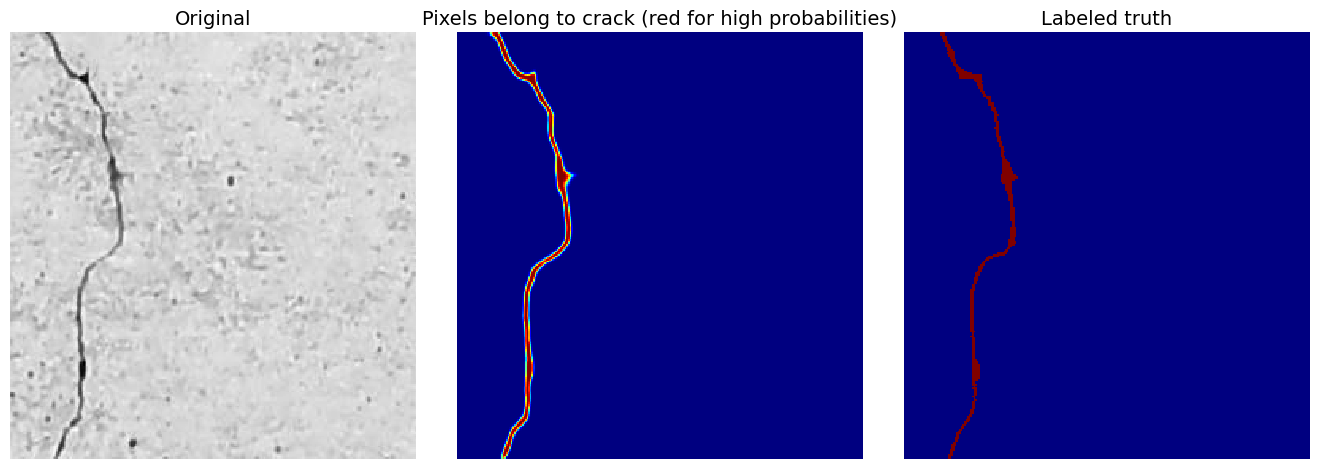

In [ ]:
i_sample = random.randint(0, X_test.shape[0]-1)

fig, AX = plt.subplots(1, 3, figsize=(13, (13-0.2)/3))
plt.subplots_adjust(0, 0, 1, 1, hspace=0, wspace=0.1)
for ax in AX:
    ax = ax_decorate_box(ax)
AX[0].pcolormesh(np.mean(X_test[i_sample, ...,], axis=-1), cmap=plt.cm.gray)
AX[1].pcolormesh(y_pred[i_sample, ..., 0], cmap=plt.cm.jet)
AX[2].pcolormesh(y_test[i_sample, ..., 0], cmap=plt.cm.jet)

AX[0].set_title("Original", fontsize=14);
AX[1].set_title("Pixels belong to crack (red for high probabilities)", fontsize=14);
AX[2].set_title("Labeled truth", fontsize=14);